In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from tensorflow import keras
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [3]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mr;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7327/861871/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1623912388&Signature=pszgOB%2FcJXdB4q6V4yHo%2FOUKp%2BA477Ea%2Fy1cI33wTzSKIdIghvw1fCbqj49VMMhQpxNFYzq5H7RZ1i4LLwmn4M1zhNFpwbnW2q456F5ruj1rx14VePqtBCvRKw2ElKswNmYkES7EMSLjgnRn%2FTMuRzroAImAPTMGNW54fCf7JRsaz1TcD6323DtdGCzzb%2BnL4sKHOA%2F99WJiTKopFAUm4%2F9k%2FXlyc1IJhkP3wlNyxi3ns0%2FgNPjS%2BCOT2sf3%2B%2FORWfyw%2BfFnx90UKUzggj9emraTrnqZOjz7bCaqMXShpgLtMP8cMGFH628jL%2BvOOWdh%2FNgDdh%2BxFlRj4ki%2B3gVBTw%3D%3D&response-content-disposition=attachment%3B+filename%3Ddog-breed-identification.zip" -c -O 'dog-breed-identification.zip'

--2021-06-16 16:15:00--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7327/861871/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1623912388&Signature=pszgOB%2FcJXdB4q6V4yHo%2FOUKp%2BA477Ea%2Fy1cI33wTzSKIdIghvw1fCbqj49VMMhQpxNFYzq5H7RZ1i4LLwmn4M1zhNFpwbnW2q456F5ruj1rx14VePqtBCvRKw2ElKswNmYkES7EMSLjgnRn%2FTMuRzroAImAPTMGNW54fCf7JRsaz1TcD6323DtdGCzzb%2BnL4sKHOA%2F99WJiTKopFAUm4%2F9k%2FXlyc1IJhkP3wlNyxi3ns0%2FgNPjS%2BCOT2sf3%2B%2FORWfyw%2BfFnx90UKUzggj9emraTrnqZOjz7bCaqMXShpgLtMP8cMGFH628jL%2BvOOWdh%2FNgDdh%2BxFlRj4ki%2B3gVBTw%3D%3D&response-content-disposition=attachment%3B+filename%3Ddog-breed-identification.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 724495926 (691M) [application/zip]
Saving to: ‘dog-b

In [4]:
!unzip -qq dog-breed-identification.zip     
!rm -rf dog-breed-identification.zip

In [5]:
#labels we are considering for this assignment
labels = ['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']

#labels in original dataset
label_df = pd.read_csv('labels.csv')
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
#no of files in original dataset
train_files = sorted(os.listdir('/content/train'))
print(len(train_files))

10222


In [7]:
#removing images which dont have the labels which we wanted

label_df = label_df[label_df['breed'].isin(labels)]
label_df['id'] = label_df['id'].apply(lambda x : x+'.jpg')    #getting directory of all files

label_df

,id,breed
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever
9,0042188c895a2f14ef64a918ed9c7b64.jpg,scottish_deerhound
20,008b1271ed1addaccf93783b39deab45.jpg,doberman
25,00a366d4b4a9bbb6c8a63126697b7656.jpg,golden_retriever
37,0100f55e4f0fe28f2c0465d3fc4b9897.jpg,golden_retriever
...,...,...
10158,fe50bac6c389d137ea01c9cfc7346ca8.jpg,scottish_deerhound
10161,fe624532170510bd80627c0500bafc97.jpg,tibetan_mastiff
10170,feb16cf86c9dac6d476e3c372ba5c279.jpg,pug
10172,febcab8eb2da444bf83336cffec7eb92.jpg,golden_retriever


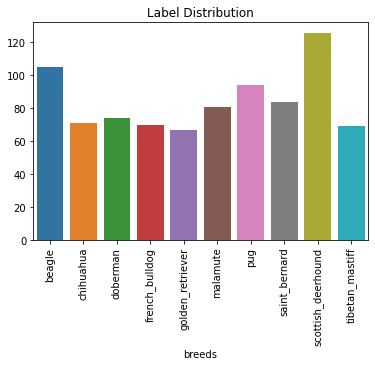

In [8]:
#lables distribution

_,counts = np.unique(label_df['breed'].values, return_counts=True)
sns.barplot(x=labels, y=counts)
plt.xlabel("breeds")
plt.xticks(rotation=90)
plt.title("Label Distribution")
plt.show()

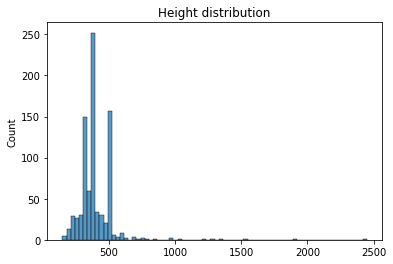

In [9]:
#analysying the size of the images
heights = []
widths = []
for i in label_df['id']:
  img = cv.imread("/content/train/"+i)
  heights.append(img.shape[0])
  widths.append(img.shape[1])

sns.histplot(x=heights)
plt.title("Height distribution")
plt.show()

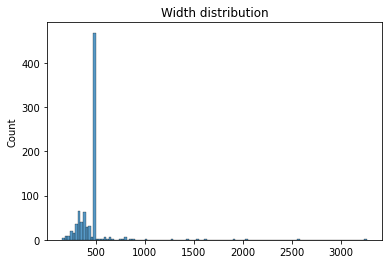

In [10]:
sns.histplot(x=widths)
plt.title("Width distribution")
plt.show()

In [11]:
#preprocessing data
train_data, valid_data = train_test_split(label_df, test_size=0.15, random_state=42)

def preprocess(df):
  X = []
  for i in df['id']:
    img_path = '/content/train/'+i
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    X.append(x)
  
  y = df['breed'].astype('category').cat.codes.values
  y = keras.utils.to_categorical(y, num_classes=10)

  return np.array(X), y

X_train, y_train = preprocess(train_data)
X_valid, y_valid = preprocess(valid_data)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(714, 224, 224, 3) (714, 10)
(127, 224, 224, 3) (127, 10)


In [ ]:
#modeling
keras.backend.clear_session()

input = keras.layers.Input(shape=(224,224,3))
resnet_50 = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=input)

#joining a simple dnn to resnet50
output = keras.layers.GlobalAveragePooling2D()(resnet_50.output)
output = keras.layers.BatchNormalization()(output)
output = keras.layers.Dense(256, activation='relu')(output)
output = keras.layers.Dropout(0.5)(output)
output = keras.layers.BatchNormalization()(output)
output = keras.layers.Dense(128, activation='relu')(output)
output = keras.layers.Dropout(0.5)(output)
output = keras.layers.BatchNormalization()(output)
output = keras.layers.Dense(64, activation='relu')(output)
output = keras.layers.Dropout(0.5)(output)
output = keras.layers.BatchNormalization()(output)
output = keras.layers.Dense(10,activation='softmax')(output)

model = keras.Model(inputs=input, outputs=output)

In [13]:
#transfer learning: fine tuning the resnet50 model (only training top layers)

for layer in model.layers[:175]:
    layer.trainable=False

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
#training
acc = keras.metrics.Accuracy()
auc = keras.metrics.AUC()
adam = keras.optimizers.Adam()

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy',auc])

model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_valid,y_valid))

Epoch 1/10
45/45 [==============================] - 42s 207ms/step - loss: 2.7394 - accuracy: 0.1569 - auc: 0.5522 - val_loss: 1.6364 - val_accuracy: 0.5669 - val_auc: 0.8930
Epoch 2/10
45/45 [==============================] - 7s 148ms/step - loss: 2.1331 - accuracy: 0.2633 - auc: 0.7123 - val_loss: 1.3026 - val_accuracy: 0.7244 - val_auc: 0.9611
Epoch 3/10
45/45 [==============================] - 7s 148ms/step - loss: 1.8620 - accuracy: 0.3796 - auc: 0.7817 - val_loss: 0.9606 - val_accuracy: 0.8504 - val_auc: 0.9876
Epoch 4/10
45/45 [==============================] - 7s 148ms/step - loss: 1.7391 - accuracy: 0.4356 - auc: 0.8123 - val_loss: 0.8335 - val_accuracy: 0.8504 - val_auc: 0.9903
Epoch 5/10
45/45 [==============================] - 7s 148ms/step - loss: 1.4874 - accuracy: 0.4930 - auc: 0.8674 - val_loss: 0.6563 - val_accuracy: 0.9134 - val_auc: 0.9947
Epoch 6/10
45/45 [==============================] - 7s 149ms/step - loss: 1.3368 - accuracy: 0.5476 - auc: 0.8984 - val_loss: 0.5

In [16]:
valid_data.head()

,id,breed
5695,8fa8a4c1355b991d8641c8fcd471e9b3.jpg,saint_bernard
9901,f8cc0c4e9be6827494a77260d383884f.jpg,pug
410,09d497888fd1e6745f67a78269139620.jpg,malamute
6519,a42494c29d0cd8099e0da27de9cc9373.jpg,malamute
1244,1ebf07f4fc0f44b6befec9aa3cd8adbb.jpg,beagle


In [23]:
#prediction on test data
y_pred = []
pred_proba = []

for i in valid_data['id']:
  img_path = '/content/train/'+i
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  pred_proba.append(preds[0])
  label_id = preds.argmax(axis=-1)
  pred_label = labels[label_id[0]]
  y_pred.append(pred_label)

In [24]:
#accuracy
y_true = valid_data['breed'].values 
print("Accuracy on test data: ",accuracy_score(y_true,y_pred))

Accuracy on test data:  0.952755905511811


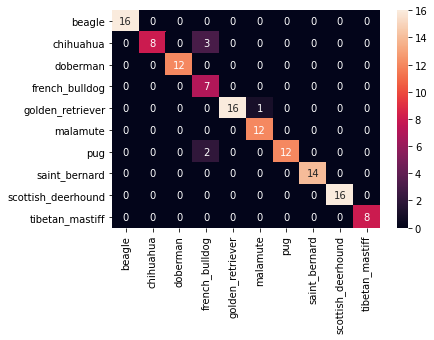

In [25]:
#confusion_matrix

cf_matrix = confusion_matrix(y_true,y_pred)
df_cm = pd.DataFrame(cf_matrix, index = labels,
                  columns = labels)

sns.heatmap(df_cm, annot=True)

In [26]:
#f1_score
print("F1_score on test data:",f1_score(y_true,y_pred, average = 'macro'))

F1_score on test data: 0.9431721261194944


In [29]:
#roc_auc_score

print("roc_auc_score on test data:", roc_auc_score(y_true, pred_proba, multi_class='ovr'))

roc_auc_score on test data: 0.9989546164403009


In [ ]:
#saving model
model.save('model.h5')